<a href="https://colab.research.google.com/github/ebamberg/research-projects-ml/blob/main/Document_Management/examples_build_knowledge_graph_with_instructor_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup projects and dependencies

In [1]:
!pip install ollama langchain_community  --quiet

modelid="llama3.1"
emb_modelid="mxbai-embed-large"
host="localhost:11434"

get_ipython().system_raw("curl -fsSL https://ollama.com/install.sh | sh")
get_ipython().system_raw("ollama serve &")
get_ipython().system_raw(f"ollama pull {modelid}")
get_ipython().system_raw(f"ollama pull {emb_modelid}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install instructor --quiet
!apt install libgraphviz-dev
!pip install pygraphviz



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/mai

In [3]:

import instructor

from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List

llm = OpenAI(
        base_url=f"http://{host}/v1",
        api_key="ollama",  # required, but unused
    )

client = instructor.from_openai(
    llm,
    mode=instructor.Mode.JSON,
)

## create a general knowledge graph

In [ ]:
from pydantic import BaseModel, Field
from typing import Optional
from graphviz import Digraph
# from IPython.display import display

class Node(BaseModel):
    id: int
    label: str
    color: str = "black"
    def __hash__(self) -> int:
        return hash((id, self.label))

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"
    def __hash__(self) -> int:
        return hash((self.source, self.target, self.label))


class KnowledgeGraph(BaseModel):
    nodes: Optional[list[Node]] = Field(..., default_factory=list)  # A list of nodes in the knowledge graph.
    edges: Optional[list[Edge]] = Field(..., default_factory=list)  # A list of edges in the knowledge graph.

    def update(self, other: "KnowledgeGraph") -> "KnowledgeGraph":
        # This method updates the current graph with the other graph, deduplicating nodes and edges.
        return KnowledgeGraph(
            nodes=list(set(self.nodes + other.nodes)),  # Combine and deduplicate nodes
            edges=list(set(self.edges + other.edges)),  # Combine and deduplicate edges
        )

    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(name=str(node.id), label=node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        return dot
        # return display(dot)

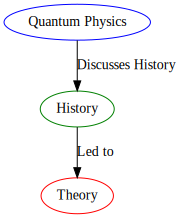

In [ ]:
def generate_simple_graph(input) -> KnowledgeGraph:
    return client.chat.completions.create(
        model=modelid,
        messages=[
            {
                "role": "user",
                "content": f"Help me understand the following by describing it as small knowledge graph: {input}",
            }
        ],
        response_model=KnowledgeGraph,
    )

graph=generate_simple_graph("Explain quantum mechanics").visualize_knowledge_graph()
graph

In [ ]:
def generate_graph(input: list[str]) -> KnowledgeGraph:
    # Initialize an empty KnowledgeGraph
    cur_state = KnowledgeGraph()

    # Iterate over the input list
    for i, inp in enumerate(input):
        new_updates = client.chat.completions.create(
            model=modelid,
            messages=[
                {
                    "role": "system",
                    "content": """You are an iterative knowledge graph builder.
                    You are given the current state of the graph, and you must append the nodes and edges
                    to it Do not procide any duplcates and try to reuse nodes as much as possible.""",
                },
                {
                    "role": "user",
                    "content": f"""Extract any new nodes and edges from the following:
                    # Part {i}/{len(input)} of the input:

                    {inp}""",
                },
                {
                    "role": "user",
                    "content": f"""Here is the current state of the graph:
                    {cur_state.model_dump_json(indent=2)}""",
                },
            ],
            response_model=KnowledgeGraph,
        )  # type: ignore

        # Update the current state with the new updates
        cur_state = cur_state.update(new_updates)

        # Draw the current state of the graph
        cur_state.visualize_knowledge_graph()

    # Return the final state of the KnowledgeGraph
    return cur_state

text_chunks = [
    "Jason knows a lot about quantum mechanics. He is a physicist. He is a professor",
    "Professors are smart.",
    "Sarah knows Jason and is a student of his.",
    "Sarah is a student at the University of Toronto. and UofT is in Canada.",
]

graph: KnowledgeGraph = generate_graph(text_chunks)

graph.visualize_knowledge_graph()

# Extract Persons and Relationship from Story

In [9]:
get_ipython().system_raw(f"ollama pull {modelid}")

### create synthetic data for testing

In [51]:
system = "Your are a horror thriller novel author who likes to write in the style of Steven King."
prompt = """
Write a short and thrilling horror story about a 6 piece family that spend their holiday in a cabin. The story should be between 1000 and 2000 words.

The family is a father, a mother, 2 children, aunt , uncle and grandparents.
At least one of the characters is a ghost.
Mention all the characters and their relationship in the story.
"""
story_response=llm.chat.completions.create(model=modelid, messages = [{"role":"system", "content":system},{"role":"user", "content":prompt}])
story = story_response.choices[0].message.content
story

'**The Isolation of Raven\'s Peak**\n\nIt was supposed to be a relaxing holiday for the Thompson family. A week-long stay at the secluded cabin on Raven\'s Peak, nestled deep within the heart of the Appalachian mountains. The family had been looking forward to it all year - a chance to reconnect and unplug from the stresses of daily life.\n\nJohn, the patriarch, a gruff but lovable man in his late 40s, had brought his wife, Karen, a sweet and nurturing soul, along with their two children, Emily (12) and James (9). John\'s sister, Rachel, and her husband, Michael, were also part of the family gathering. They were all joined by John and Karen\'s parents, Henry and Margaret.\n\nAs they arrived at the cabin, the group couldn\'t help but feel a sense of excitement and rejuvenation wash over them. The crisp mountain air, the scent of pine trees, and the sound of the gentle brook nearby set a soothing tone for their stay.\n\nHowever, as night began to fall on the first evening, an eerie atmos

### Our Knowledge Graph Model

In [64]:
from pydantic import BaseModel, Field
from typing import Optional

class Character(BaseModel):
    id: str
    name: str = "unnamed"
    description: str = "no description"
    def __hash__(self) -> int:
        return hash((id, self.name))

class Relationship(BaseModel):
    id: str
    source: str
    target: str
    label: str = "unknown relation"
    description: str = "no description"
    def __hash__(self) -> int:
        return hash((self.source, self.target, self.label))

class KnowledgeGraph(BaseModel):
    nodes: Optional[list[Character]] = Field(..., default_factory=list)
    edges: Optional [ list[Relationship] ] = Field(..., default_factory=list)


In [65]:
def generate_relationship_graph(input) -> KnowledgeGraph:
    return client.chat.completions.create(
        model=modelid,
        messages=[
            {"role": "system", "content": "You are an knowledge graph builder."},
            {
                "role": "user",
                "content": f"Extract the characters and their relationship from the following story as a knowledge graph. examples a relationship are Dad,Mum, Son, Daughter, Uncle, Aunt. Story: {input}",
            }
        ],
        response_model=KnowledgeGraph,
    )


relationships=generate_relationship_graph(story)
relationships


KnowledgeGraph(nodes=[Character(id='John', name='John Thompson', description='Patriarch, father of Emily and James'), Character(id='Karen', name='Karen Thompson (née Murphy)', description='Mother of Emily and James'), Character(id='Emily', name='Emily Thompson', description='Daughter, age 12'), Character(id='James', name='James Thompson', description='Son, age 9'), Character(id='Rachel', name='Rachel (Thompson) (née Henry)', description="John's sister, wife of Michael"), Character(id='Michael', name='Michael (no last name mentioned)', description='Husband of Rachel'), Character(id='Henry', name='Henry (née Murphy)', description="John and Karen's father, husband of Margaret"), Character(id='Margaret', name='Margaret', description="John and Karen's mother who passed away 20 years ago")], edges=[Relationship(id='Dad-Son', source='John', target='James', label='Father of (Family)', description="John is James' father."), Relationship(id='Mum-Daughter', source='Karen', target='Emily', label='

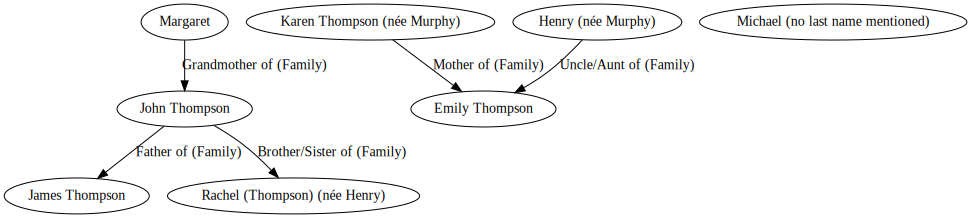

In [66]:
from graphviz import Digraph

def visualize_relationship_graph(data: KnowledgeGraph):
        dot = Digraph(comment="Relationships")

        for node in data.nodes:
            dot.node(name=str(node.id), label=node.name, color="black")
        for edge in data.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color="black")
        return dot

graph=visualize_relationship_graph(relationships)
graph